# Сборный проект. Анализ и предсказание продаж по компьютерным играм.

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Не важно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

Датафрейм имеет следующую структуру:

- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы долларов)
- EU_sales — продажи в Европе (миллионы долларов)
- JP_sales — продажи в Японии (миллионы долларов)
- Other_sales — продажи в других странах (миллионы долларов)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

План работы над проектом:

1. Просмотреть таблицу и выявить аномалии и пропущенные значения.
2. Провести предобработку таблицы: замена столбцов, заполнение пропусков, удаление дубликатов и т.д.
3. Провести анализ по данным и подготовить актуальные данные.
4. Составить портреты пользователей для купных регионов продаж.
5. Выполнить проверку гипотез.
6. Оформить проект и сделать выводы по каждому шагу.

## Работа с таблицей и поиск аномалий

In [1]:
import pandas as pd
import copy
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy import stats as st
import numpy as np

In [2]:
df = pd.read_csv('/datasets/games.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


таблица состоит из 11 столбцов и 16715 строк. есть строки с пропусками

## Предобработка данных

In [3]:
print(df.columns)
#посмотрим значения в столбцах для выявления нестандартных значений и ошибок, 
for row in df:
    print(row)
    print()
    print(df[row].value_counts())


Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'NA_sales', 'EU_sales',
       'JP_sales', 'Other_sales', 'Critic_Score', 'User_Score', 'Rating'],
      dtype='object')
Name

Need for Speed: Most Wanted                     12
Ratatouille                                      9
FIFA 14                                          9
LEGO Marvel Super Heroes                         9
Madden NFL 07                                    9
                                                ..
Automobili Lamborghini                           1
Medieval Moves: Deadmund's Quest                 1
Silent Hunter III                                1
Quiz Magic Academy DS: Futatsu no Jikuu Koku     1
Hakuouki: Zuisouroku                             1
Name: Name, Length: 11559, dtype: int64
Platform

PS2     2161
DS      2151
PS3     1331
Wii     1320
X360    1262
PSP     1209
PS      1197
PC       974
XB       824
GBA      822
GC       556
3DS      520
PSV      430
PS4      392
N64      319
XOne     247

В столбце с Name есть повторения названиями игр. Они возникли из-за того что на каждую платформу есть такая игра. но надо проверить все ли верно. 
В столбце с продажами есть 0, значит данные игры не прдавались в этих регионах. 
Столбцы Year_of_Release имеет тип данных float64

Все наши столбцы имеют разные регистры. необходимо привести их к единому регистру. 

In [4]:
df.columns = df.columns.str.lower()

In [5]:
#далее нам необходимо найти и удалить пропуски  

print(df['year_of_release'].isna().value_counts())
print(df['name'].isna().value_counts())
print(df['genre'].isna().value_counts())
print(df['critic_score'].isna().value_counts())
print(df['user_score'].isna().value_counts())
print(df['rating'].isna().value_counts())

False    16446
True       269
Name: year_of_release, dtype: int64
False    16713
True         2
Name: name, dtype: int64
False    16713
True         2
Name: genre, dtype: int64
True     8578
False    8137
Name: critic_score, dtype: int64
False    10014
True      6701
Name: user_score, dtype: int64
False    9949
True     6766
Name: rating, dtype: int64


In [6]:
df.dropna(subset=['name', 'genre', 'year_of_release'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
name               16444 non-null object
platform           16444 non-null object
year_of_release    16444 non-null float64
genre              16444 non-null object
na_sales           16444 non-null float64
eu_sales           16444 non-null float64
jp_sales           16444 non-null float64
other_sales        16444 non-null float64
critic_score       7983 non-null float64
user_score         9839 non-null object
rating             9768 non-null object
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


In [7]:
df = df.query('year_of_release > 1980')
df['year_of_release'] = df['year_of_release'].astype('int')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16435 entries, 0 to 16714
Data columns (total 11 columns):
name               16435 non-null object
platform           16435 non-null object
year_of_release    16435 non-null int64
genre              16435 non-null object
na_sales           16435 non-null float64
eu_sales           16435 non-null float64
jp_sales           16435 non-null float64
other_sales        16435 non-null float64
critic_score       7983 non-null float64
user_score         9839 non-null object
rating             9768 non-null object
dtypes: float64(5), int64(1), object(5)
memory usage: 1.5+ MB


In [8]:
df=df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16435 entries, 0 to 16714
Data columns (total 11 columns):
name               16435 non-null object
platform           16435 non-null object
year_of_release    16435 non-null int64
genre              16435 non-null object
na_sales           16435 non-null float64
eu_sales           16435 non-null float64
jp_sales           16435 non-null float64
other_sales        16435 non-null float64
critic_score       7983 non-null float64
user_score         9839 non-null object
rating             9768 non-null object
dtypes: float64(5), int64(1), object(5)
memory usage: 1.5+ MB


Пропуски заполнить не получится, так как у нас будет совершенно некорректная выборка. 
У нас есть "tbd" в столбце user_score. это данные без оценки. их надо заменить на более понятные пропуски для нас. 

In [9]:
df.loc[df['user_score'] == 'tbd', 'user_score'] = float('NaN')
df['user_score'].value_counts()
df['rating']=df['rating'].fillna('unknown')
df['user_score'] = df['user_score'].astype('float64')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16435 entries, 0 to 16714
Data columns (total 11 columns):
name               16435 non-null object
platform           16435 non-null object
year_of_release    16435 non-null int64
genre              16435 non-null object
na_sales           16435 non-null float64
eu_sales           16435 non-null float64
jp_sales           16435 non-null float64
other_sales        16435 non-null float64
critic_score       7983 non-null float64
user_score         7463 non-null float64
rating             16435 non-null object
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


In [10]:
df[df['name'] == 'Need for Speed: Most Wanted' ]  
df

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,unknown
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,unknown
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,unknown
16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,NaN,NaN,unknown
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,unknown
16713,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,NaN,NaN,unknown


как видим дипликаты есть только в одной игре. скорее всего это случилось из-за того были разные релизы игры. 

In [11]:
df['total_sales'] = df.apply(lambda row: sum(row[['na_sales','eu_sales','jp_sales','other_sales']]),axis =1)
df

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,unknown,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,unknown,31.38
...,...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,unknown,0.01
16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,NaN,NaN,unknown,0.01
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,unknown,0.01
16713,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,NaN,NaN,unknown,0.01


****Вывод по шагу 2****
- Замените названия столбцов (приведите к нижнему регистру); **Сделано**
- Преобразуйте данные в нужные типы. Опишите, в каких столбцах заменили тип данных и почему; **Заменил тип данных в столбце с годом реализации, так как он имел тип с плавающей запятой. а у нас должно быть целое число.**
- Обработайте пропуски при необходимости:

	Объясните, почему заполнили пропуски определённым образом или почему не стали это делать; **Пропуски были удалены во всех столбцах, кроме тех что влияют на рейтинг. так как при удалении мы потеряем большой массив данных, а при замены на медиану или среднее число, эти жанные будут не корректны. так же заменили "tbd" на  Nan. чтобы программа понимала что это пропуски а не просто текст**
    
	Опишите причины, которые могли привести к пропускам; **пропуски в столбцах Название, год и жанр появились из-за ошибок ввода данных**
	Обратите внимание на аббревиатуру 'tbd' в столбцах с рейтингом. Отдельно разберите это значение и опишите, как его обработать; **TBD - аббревиатура от английского To Be Determined (будет определено) или To Be Decided (будет решено). Используется, если какая-то информация еще не определена или решение по вопросу не принято. у нас данное значение в столбце с оценкой, что означает что данные еще не были подгружены или их мало для выставления каких-либо оценок**
- Посчитайте суммарные продажи во всех регионах и запишите их в отдельный столбец. 


 ## Проведите исследовательский анализ данных

###	Посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?

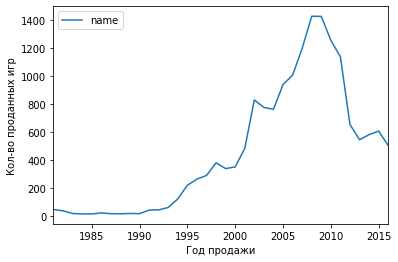

,name
year_of_release,
1981,46
1982,36
1983,17
1984,14
1985,14
1986,21
1987,16
1988,15
1989,17


In [12]:
years_groupby = df.groupby('year_of_release').agg({'name':'count'})
years_groupby.plot()
plt.xlabel('Год продажи')
plt.ylabel('Кол-во проданных игр')
plt.show()
years_groupby

Пик выхода игр приходится 2009 год. думаю что важны данные начиная с 1995 года. Когда выпуск игр стал более 200 млн экз. 

###	Посмотрите, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?

In [13]:
platforms_groupby = df.groupby('platform').agg({'total_sales':'sum'})
best_platforms_groupby=platforms_groupby.sort_values('total_sales', ascending = False)
best_platforms_groupby

,total_sales
platform,
PS2,1233.56
X360,961.24
PS3,931.34
Wii,891.18
DS,802.78
PS,727.58
PS4,314.14
GBA,312.88
PSP,289.53


In [14]:
best_platforms_groupby = list(best_platforms_groupby.index[:5])
best_platforms_groupby

['PS2', 'X360', 'PS3', 'Wii', 'DS']

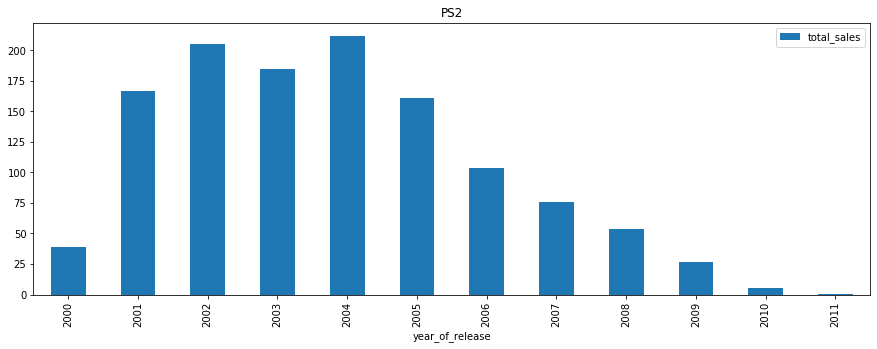

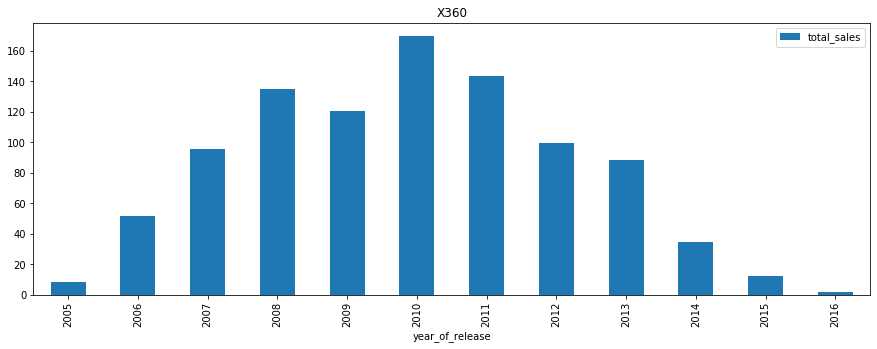

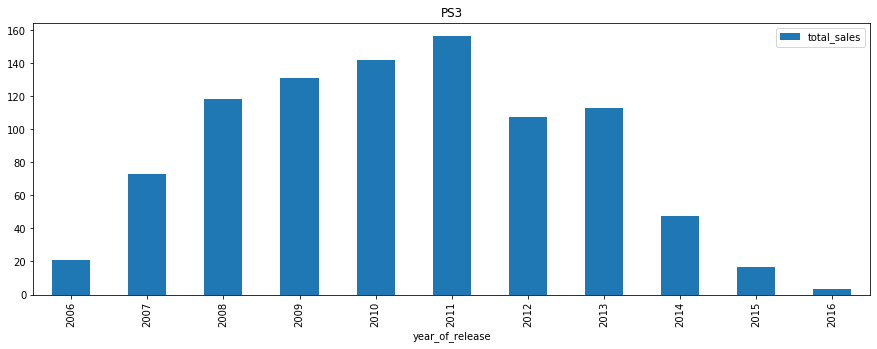

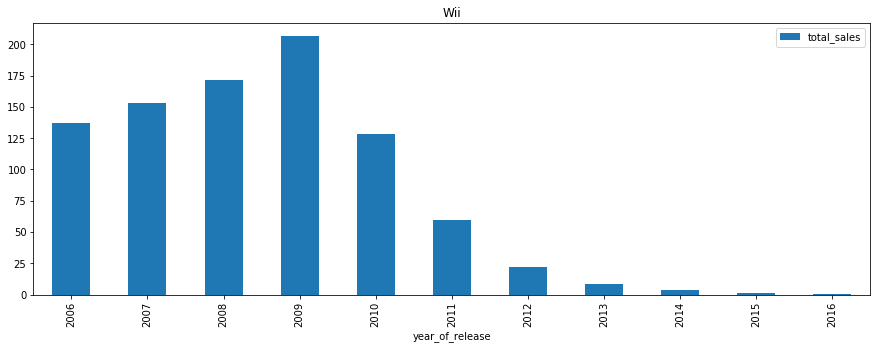

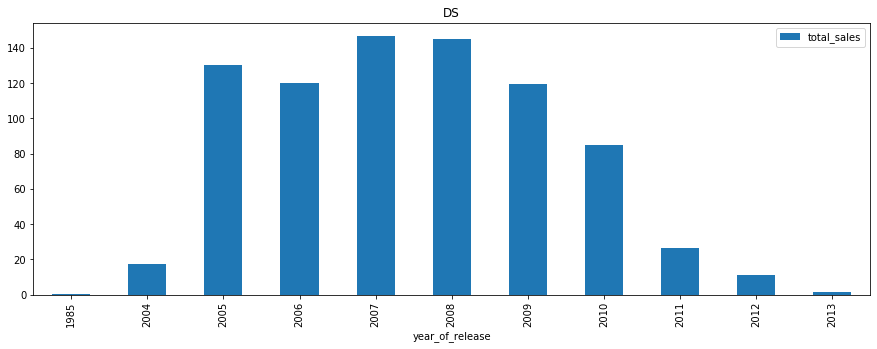

In [15]:
for platform in best_platforms_groupby:
    df[df['platform'] == platform].pivot_table(index='year_of_release', values='total_sales', aggfunc='sum').plot(kind='bar', figsize=(15,5))
    plt.title(platform)

Средняя продолжительность продажи платформ: 7.645161290322581


,duration_sales_in_year
count,31.000000
mean,7.645161
std,5.069835
min,1.000000
25%,4.000000
50%,7.000000
75%,11.000000
max,26.000000


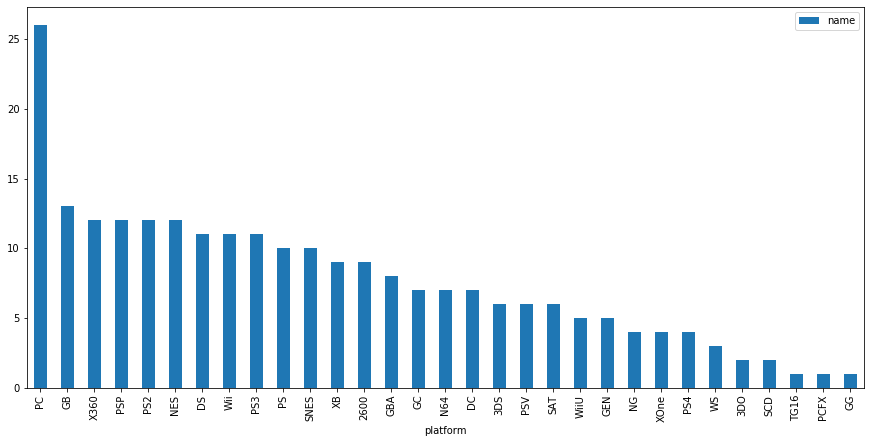

In [116]:
duration = pd.pivot_table(df, index=[ 'platform', 'year_of_release' ], 
                                     values='name', aggfunc = 'count')
dur_plat=pd.pivot_table(duration, index=['platform'],values='name', aggfunc = 'count').sort_values('name', ascending = False)
dur_plat.plot(kind='bar', figsize=(15, 7))

dur_plat.rename(columns={'name': 'duration_sales_in_year'}, inplace=True)
print('Средняя продолжительность продажи платформ:',dur_plat['duration_sales_in_year'].mean())

dur_plat.describe()

среднее время продолжительности жизни платформы 7,6 лет. минимальная 1 год а макисмальная 26

### Возьмите данные за соответствующий актуальный период. Актуальный период определите самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год

За актуальный период возьмем 2013-2016 год. 

In [16]:
actual_df = df.query('year_of_release >= 2013')
actual_df

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,unknown,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,unknown,14.60
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
...,...,...,...,...,...,...,...,...,...,...,...,...
16703,Strawberry Nauts,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,unknown,0.01
16707,Aiyoku no Eustia,PSV,2014,Misc,0.00,0.00,0.01,0.00,NaN,NaN,unknown,0.01
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,unknown,0.01
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,unknown,0.01


по актуальным данным видно что в нашу выборку попало 2233 строки. 

###	Какие платформы лидируют по продажам, растут или падают

In [17]:
act_platforms_pivot = pd.pivot_table(actual_df, index=[ 'platform','year_of_release' ], 
                                     values='total_sales', aggfunc = 'sum')

act_platforms_pivot

total_sales
platform year_of_release             
3DS      2013                   56.57
         2014                   43.76
         2015                   27.78
         2016                   15.14
DS       2013                    1.54
PC       2013                   12.38
         2014                   13.28
         2015                    8.52
         2016                    5.25
PS3      2013                  113.25
         2014                   47.76
         2015                   16.82
         2016                    3.60
PS4      2013                   25.99
         2014                  100.00
         2015                  118.90
         2016                   69.25
PSP      2013                    3.14
         2014                    0.24
         2015                    0.12
PSV      2013                   10.59
         2014                   11.90
         2015                    6.25
         2016                    4.25
Wii      2013                    8.59
         2014                    3.75
         2015                    1.14
         2016                    0.18
WiiU     2013                   21.65
         2014                   22.03
         2015                   16.35
         2016                    4.60
X360     2013                   88.58
         2014                   34.74
         2015                   11.96
         2016                    1.52
XOne     2013                   18.96
         2014                   54.07
         2015                   60.14
         2016                   26.15

Выберите несколько потенциально прибыльных платформ.


In [18]:
best_platform=['3DS','PS3','PS4','X360','XOne']
best_platform

['3DS', 'PS3', 'PS4', 'X360', 'XOne']

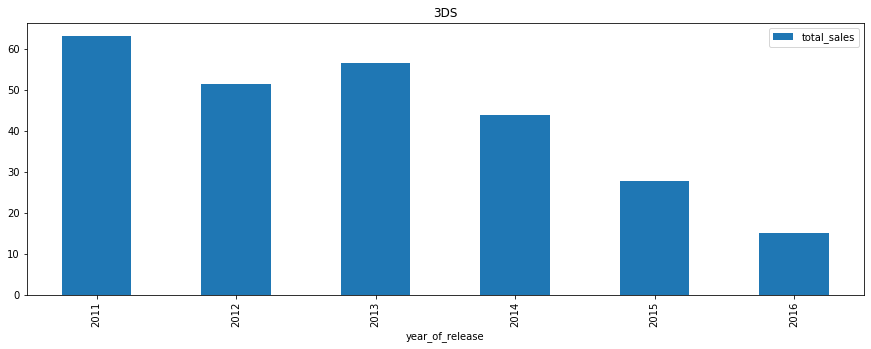

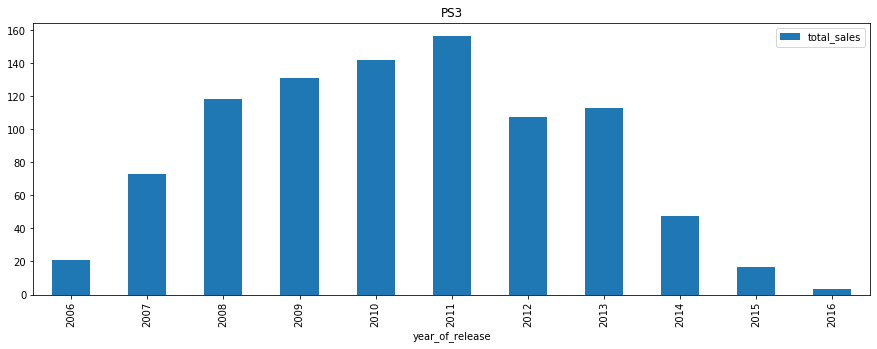

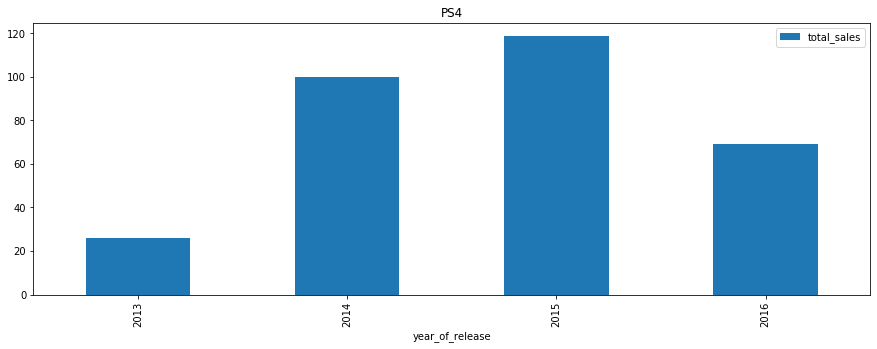

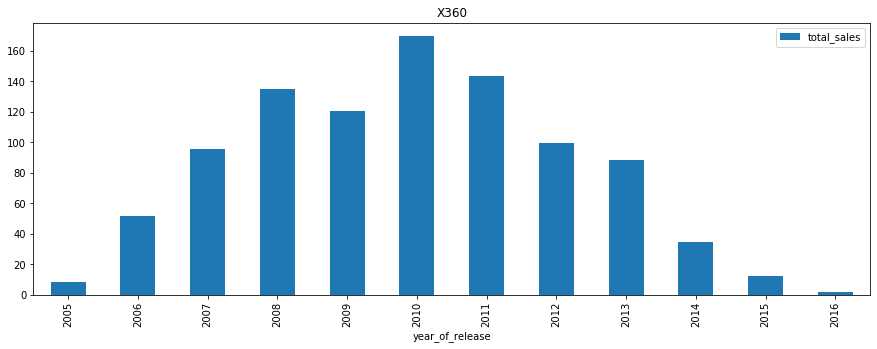

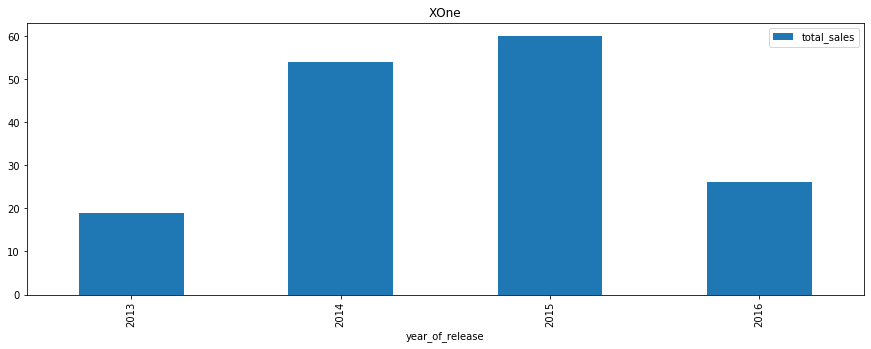

In [19]:
for platform in best_platform:
    df[df['platform'] == platform].pivot_table(index='year_of_release', values='total_sales', aggfunc='sum').plot(kind='bar', figsize=(15,5))
    plt.title(platform)

Построив графики мы смогли выяснить что перспективными на 2017 не являются следующие платформы: X360, PS3 и 3DS

### •	Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишите результат.

In [20]:
#создадим актуальную таблицу с топ платформами
actual_df1=df.query('platform in @best_platform and year_of_release>=2013')


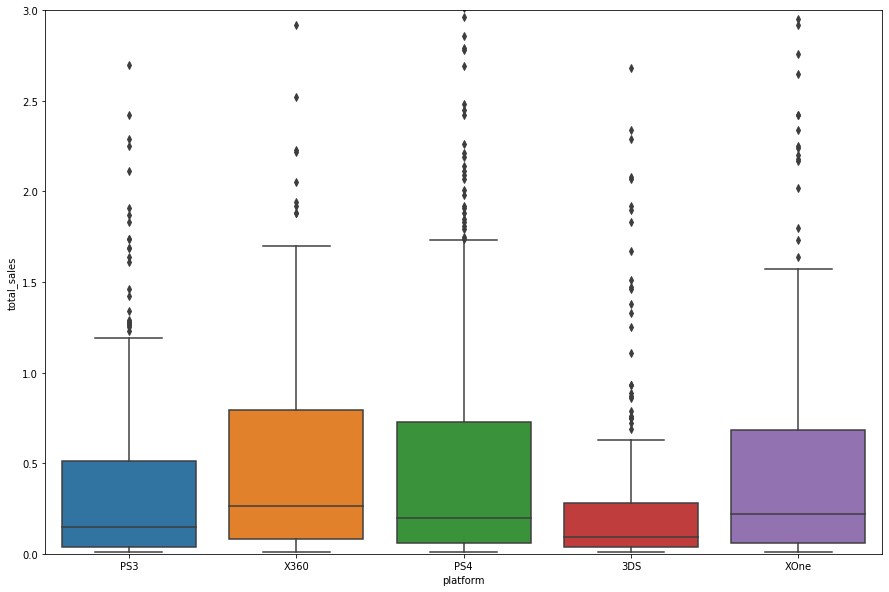

In [21]:
plt.figure(figsize=(15,10))
plt.ylim(0,3)
sns.boxplot(x='platform',y='total_sales',data=actual_df1)


просмотрев ящики с ушами можно сделать следующий вывод, что у XOne, PS4, X360 примерно одинаковая медиана продаж  
у них примерно одинаковый третий квартиль. а вот у остальных медианы меньше и 3й квартиль тоже. Но они все скошены вправо. 

### Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.

,critic_score,user_score,total_sales
critic_score,1.000000,0.557654,0.406568
user_score,0.557654,1.000000,-0.031957
total_sales,0.406568,-0.031957,1.000000


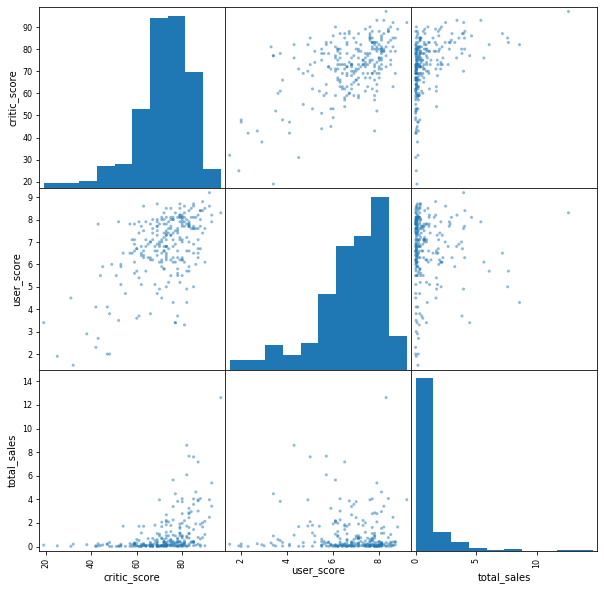

In [22]:
actual_df_PS4=actual_df.query('platform=="PS4"').loc[:,['critic_score', 'user_score', 'total_sales']]
pd.plotting.scatter_matrix(actual_df_PS4, figsize=(10, 10));
actual_df_PS4.corr()

согласно построенной матрице можно следующие суждения
1. чем выше оценка критиков тем выше оценка пользователей
2. чем выше оценка пользователей тем выше продажи
3. продажи зависят мнения критиков

### Соотнесите выводы с продажами игр на других платформах.

,critic_score,user_score,total_sales
critic_score,1.000000,0.599920,0.334285
user_score,0.599920,1.000000,0.002394
total_sales,0.334285,0.002394,1.000000


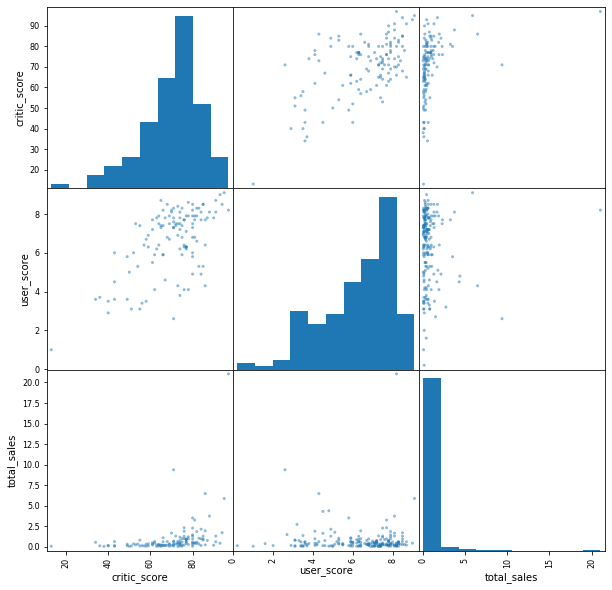

In [23]:
actual_df_PS4=actual_df.query('platform=="PS3"').loc[:,['critic_score', 'user_score', 'total_sales']]
pd.plotting.scatter_matrix(actual_df_PS4, figsize=(10, 10));
actual_df_PS4.corr()

,critic_score,user_score,total_sales
critic_score,1.000000,0.472462,0.416998
user_score,0.472462,1.000000,-0.068925
total_sales,0.416998,-0.068925,1.000000


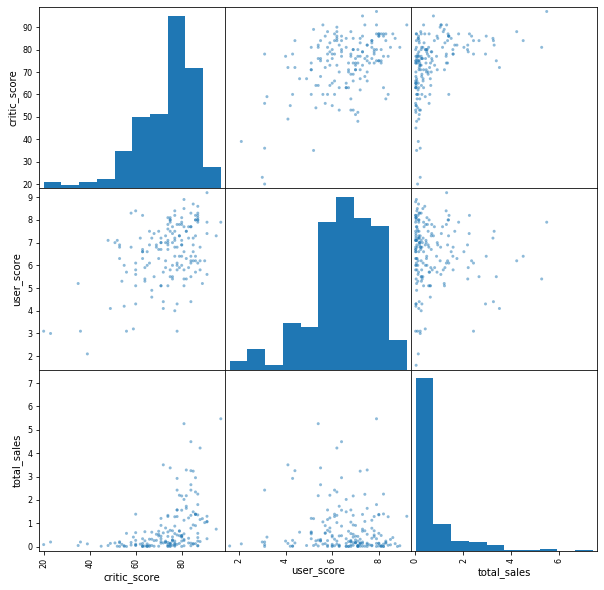

In [24]:
actual_df_PS4=actual_df.query('platform=="XOne"').loc[:,['critic_score', 'user_score', 'total_sales']]
pd.plotting.scatter_matrix(actual_df_PS4, figsize=(10, 10));
actual_df_PS4.corr()

,critic_score,user_score,total_sales
critic_score,1.000000,0.520946,0.350345
user_score,0.520946,1.000000,-0.011742
total_sales,0.350345,-0.011742,1.000000


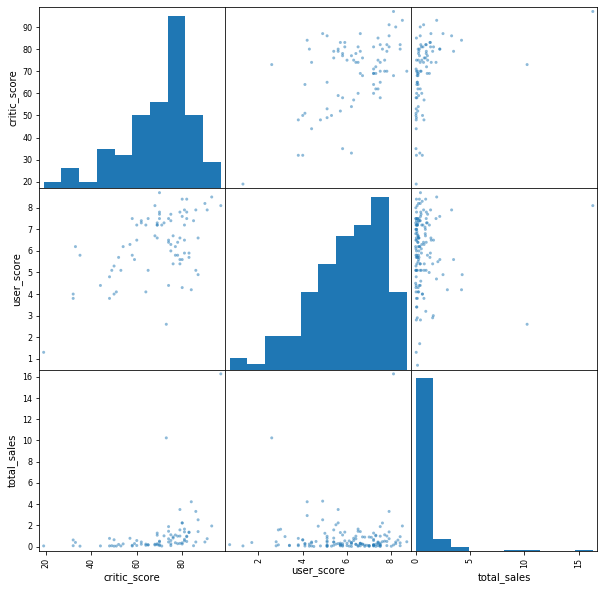

In [25]:
actual_df_PS4=actual_df.query('platform=="X360"').loc[:,['critic_score', 'user_score', 'total_sales']]
pd.plotting.scatter_matrix(actual_df_PS4, figsize=(10, 10));
actual_df_PS4.corr()

,critic_score,user_score,total_sales
critic_score,1.000000,0.769536,0.357057
user_score,0.769536,1.000000,0.241504
total_sales,0.357057,0.241504,1.000000


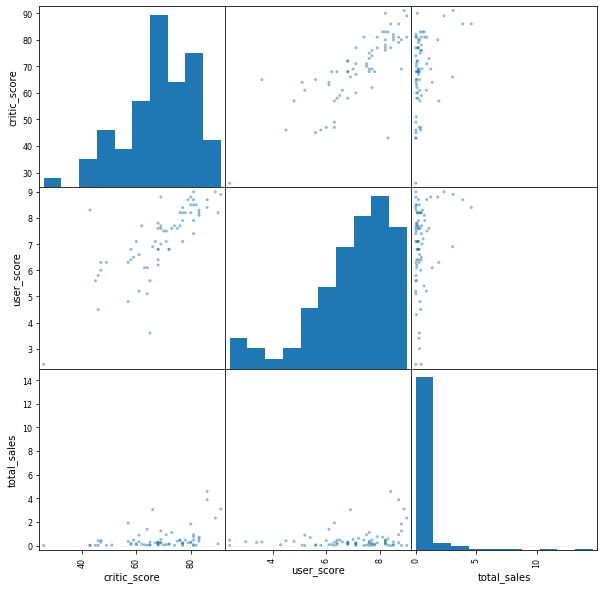

In [26]:
actual_df_PS4=actual_df.query('platform=="3DS"').loc[:,['critic_score', 'user_score', 'total_sales']]
pd.plotting.scatter_matrix(actual_df_PS4, figsize=(10, 10));
actual_df_PS4.corr()

посмотрев данные диаграммы можно сделать вывод, что зависимости одинаковы на платформах PS3, X360, XOne и PS4. 
но на 3DS немного другая ситуация. Тут наблюдается что на продажи влюят оценки пользователей чем критиков. 

###  Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

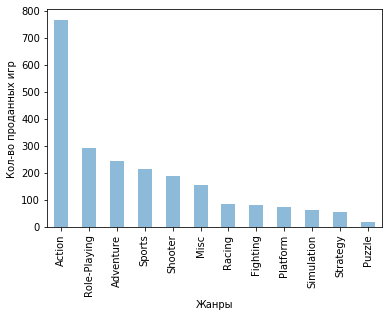

genre
Action          766
Role-Playing    292
Adventure       245
Sports          214
Shooter         187
Misc            155
Racing           85
Fighting         80
Platform         74
Simulation       62
Strategy         56
Puzzle           17
Name: total_sales, dtype: int64

In [27]:
act_genre=actual_df.groupby('genre')['total_sales'].count().sort_values(ascending=False)
act_genre.plot(kind='bar', alpha=0.5)
plt.xlabel('Жанры')
plt.ylabel('Кол-во проданных игр')
plt.show()
act_genre

Самый продаваемый жанр игр это Action

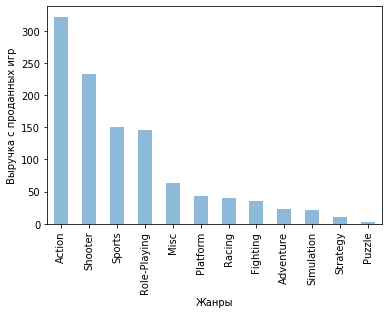

genre
Action          321.87
Shooter         232.98
Sports          150.65
Role-Playing    145.89
Misc             62.82
Platform         42.63
Racing           39.89
Fighting         35.31
Adventure        23.64
Simulation       21.76
Strategy         10.08
Puzzle            3.17
Name: total_sales, dtype: float64

In [28]:
act_genre_sum=actual_df.groupby('genre')['total_sales'].sum().sort_values(ascending=False)
act_genre_sum.plot(kind='bar', alpha=0.5)
plt.xlabel('Жанры')
plt.ylabel('Выручка с проданных игр')
plt.show()
act_genre_sum

Самый продаваемый и самый прибыльный является жанр Action. По высокой продаваемости за ним идет сразу Shooter.
Но так же самым низким по прибыльности и количеству продаж можно выделить жанр Puzzle

## Составьте портрет пользователя каждого региона

Определите для пользователя каждого региона (NA, EU, JP):
### Самые популярные платформы (топ-5). Опишите различия в долях продаж.


In [29]:
pop_platforms_pivot_na_= actual_df.pivot_table(index='platform',values=['na_sales','total_sales'],aggfunc=('sum'))
pop_platforms_pivot_na_.sort_values('na_sales', ascending = False)

,na_sales,total_sales
platform,,
PS4,108.74,314.14
XOne,93.12,159.32
X360,81.66,136.80
PS3,63.50,181.43
3DS,38.20,143.25
WiiU,29.21,64.63
PC,11.11,39.43
Wii,6.56,13.66
PSV,5.04,32.99


In [30]:
pop_platforms_pivot_eu_= actual_df.pivot_table(index='platform',values=['eu_sales','total_sales'],aggfunc=('sum'))
pop_platforms_pivot_eu_.sort_values('eu_sales', ascending = False)

,eu_sales,total_sales
platform,,
PS4,141.09,314.14
PS3,67.81,181.43
XOne,51.59,159.32
X360,42.52,136.80
3DS,30.96,143.25
PC,25.36,39.43
WiiU,19.85,64.63
PSV,6.10,32.99
Wii,5.93,13.66


In [31]:
pop_platforms_pivot_jp_= actual_df.pivot_table(index='platform',values=['total_sales','jp_sales'],aggfunc=('sum'))
pop_platforms_pivot_jp_.sort_values('jp_sales', ascending = False)

,jp_sales,total_sales
platform,,
3DS,67.81,143.25
PS3,23.35,181.43
PSV,18.59,32.99
PS4,15.96,314.14
WiiU,10.88,64.63
PSP,3.29,3.50
X360,0.51,136.80
XOne,0.34,159.32
Wii,0.05,13.66


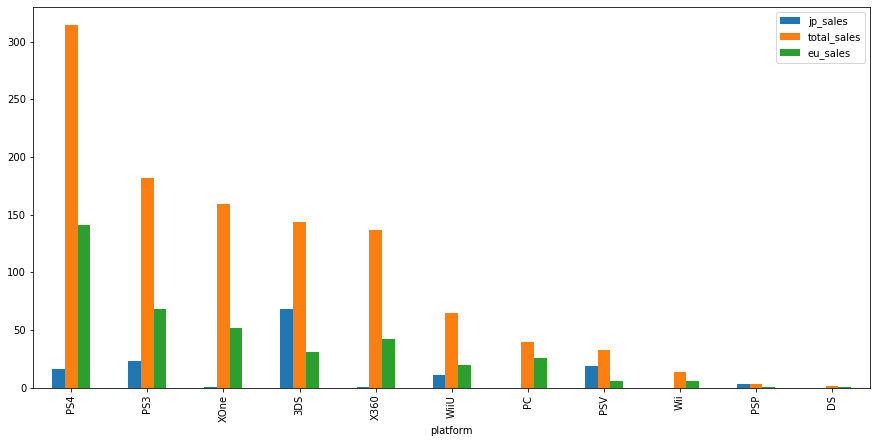

In [32]:
group_pop_platform=pop_platforms_pivot_jp_.merge(pop_platforms_pivot_eu_,on=['platform','total_sales'],how='outer') # 
#group_all=group_messages_call.merge(group_internet,on=['platform'],how='outer')
group_pop_platform.merge(pop_platforms_pivot_na_,on=['platform','total_sales'],how='outer') 
group_pop_platform.sort_values('total_sales', ascending = False).plot(kind='bar', figsize=(15, 7) )

Самые продаваемые игры на платформы 
- в Японии 3DS и PS3. Такие Топ продаж обусловлены тем что платформа 3DS это их разработка и большинство игр и платформ которые есть Европе или Америке, там не популярны. 
- в Европе PS4 и PS3. Популярность PS4 обусловлена доступностью и тем что на данную платформу выходят более качественные и эксклюзивные игры. 
- в Америке PS4 и XOne. Популярность PS4 обусловлена доступностью и тем что на данную платформу выходят более качественные и эксклюзивные игры, но так же попупулярен XOne. прямой конкурент PS

### Самые популярные жанры (топ-5). Поясните разницу.

In [33]:
pop_genre_pivot_na_= actual_df.pivot_table(index='genre',values=['na_sales','total_sales'],aggfunc=('sum'))
pop_genre_pivot_na_.sort_values('na_sales', ascending = False).head(5)

,na_sales,total_sales
genre,,
Action,126.05,321.87
Shooter,109.74,232.98
Sports,65.27,150.65
Role-Playing,46.40,145.89
Misc,27.49,62.82


In [34]:
pop_genre_pivot_eu_= actual_df.pivot_table(index='genre',values=['eu_sales','total_sales'],aggfunc=('sum'))
pop_genre_pivot_eu_.sort_values('eu_sales', ascending = False).head(5).head(5)

,eu_sales,total_sales
genre,,
Action,118.13,321.87
Shooter,87.86,232.98
Sports,60.52,150.65
Role-Playing,36.97,145.89
Racing,20.19,39.89


In [35]:
pop_genre_pivot_jp_= actual_df.pivot_table(index='genre',values=['jp_sales','total_sales'],aggfunc=('sum'))
pop_genre_pivot_jp_.sort_values('jp_sales', ascending = False).head(5).head(5)

,jp_sales,total_sales
genre,,
Role-Playing,51.04,145.89
Action,40.49,321.87
Misc,9.20,62.82
Fighting,7.65,35.31
Shooter,6.61,232.98


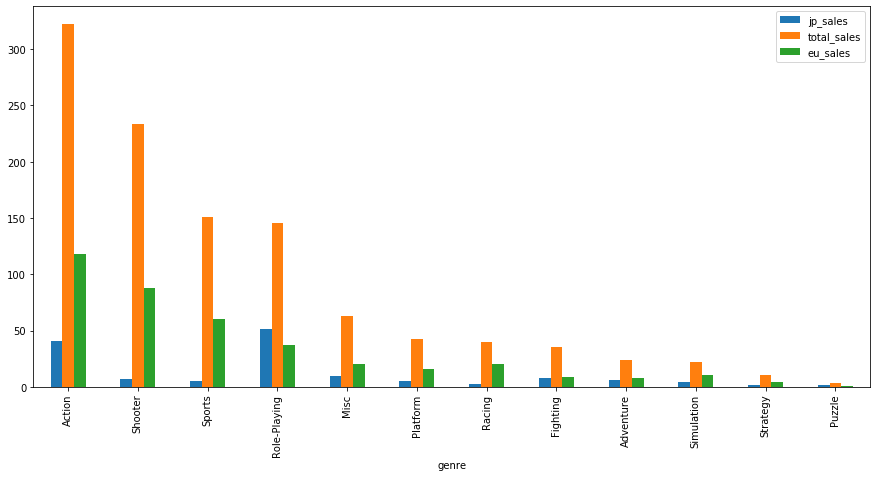

In [36]:
group_pop_genre=pop_genre_pivot_jp_.merge(pop_genre_pivot_eu_,on=['genre','total_sales'],how='outer') # 
#group_all=group_messages_call.merge(group_internet,on=['platform'],how='outer')
group_pop_genre.merge(pop_genre_pivot_na_,on=['genre','total_sales'],how='outer')
group_pop_genre.sort_values('total_sales', ascending = False).plot(kind='bar', figsize=(15, 7) )

Самые продаваемые жанры игр

в Японии Ролевые игры и Экшн. Связано это с тем что большинство платформ выпускают Аниме и прочее ролевые игры, которые любят в Японии. 
в Европе и Америке  топ жанров абсолютно одинаковый. на первом месте жанр Экшн  жанр игры где много  динамических  действий и развитие сюжета. 

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>
 
Из-за чего японский рынок игр так сильно отличается от других? 

</div>

### Влияет ли рейтинг ESRB на продажи в отдельном регионе?

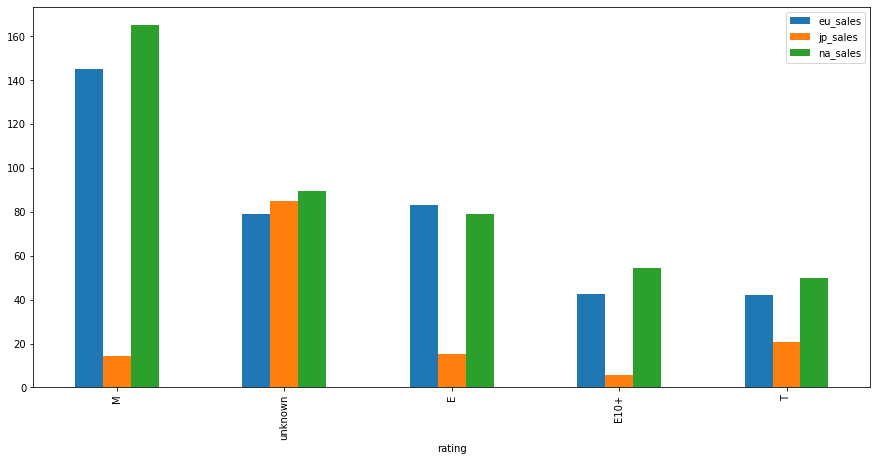

In [37]:
pop_rt_pivot=actual_df.pivot_table(index='rating',values=['na_sales','jp_sales','eu_sales'],aggfunc=('sum'))
pop_rt_pivot
pop_rt_pivot.sort_values('na_sales', ascending = False).plot(kind='bar', figsize=(15, 7))


благодаря созданной свобной таблице мы наблюдаем следующее закономерность что во всех трех регионах одинково популярны игры с рейтингом М.
Самые популярные в Америке, Японии и Европе игры с рейтингом с возрастным цензом от 17 лет(М)  
На втором месте игры в Америке и Европ для подростков для всех (Е), а в Японии игры с рейтингом от 13 лет (Т)
На третьем месте игры  в Америке и Европе игры с рейтингом(Т), а в Японии с рейтингом (Е)

Соотеветсвенно если компания захочет выпустить игру и сразу попасть в топ пробаваемых ей надо ориентироваться на рейтинг М, так как он в регионах самый популярный и в отдельных регионах популярнее игры рейтинга Т почти в 2 раза. 

**Вывод по 4 шагу**
На основе наших данных можно собрать некий образ основных покупателей по регинам:
- В Европе и С. Америке это пользователь не младше 17 лет, который любит играть в Action, чаще всего он будет играть на PS4
- В Японии это тоже пользователь не младше 17 лет, играющей в игры жанра Role-Playing на Nintendo 3DS. 

## Проверьте гипотезы

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые&

Нулевая гипотеза: cредний пользовательский рейтинг платформы XOne и PC равны.

Альтернативная гипотеза: cредний пользовательский рейтинг платформы XOne и PC не равны

In [38]:
#подговим наши тапблицы для проверки гепотих
Xbox_One_=actual_df.query('platform=="XOne"').dropna()
PC_=actual_df.query('platform=="PC"').dropna()
PC_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148 entries, 458 to 16692
Data columns (total 12 columns):
name               148 non-null object
platform           148 non-null object
year_of_release    148 non-null int64
genre              148 non-null object
na_sales           148 non-null float64
eu_sales           148 non-null float64
jp_sales           148 non-null float64
other_sales        148 non-null float64
critic_score       148 non-null float64
user_score         148 non-null float64
rating             148 non-null object
total_sales        148 non-null float64
dtypes: float64(7), int64(1), object(4)
memory usage: 15.0+ KB


In [39]:
alpha=0.05 # критический уровень статистической значимости
Xbox_One_['user_score'].mean() # Среднее значение выречки пользователей Ультра
disp_Xbox_One_=np.var(Xbox_One_['user_score'])
print('Дисперсия для платформы XOne:',disp_Xbox_One_)
std_XOne=np.sqrt(disp_Xbox_One_)
print('Стандартное отклонение для платформы XOne:',std_XOne)
print('99% значений попадают в интервал:+-',round(3*np.sqrt(disp_Xbox_One_)),'от среднего значения',round(Xbox_One_['user_score'].mean()))

Дисперсия для платформы XOne: 1.7855118457300279
Стандартное отклонение для платформы XOne: 1.3362304613089868
99% значений попадают в интервал:+- 4 от среднего значения 7


доверительный интрвал  рейтинга XOne  95%

In [40]:

PC_['user_score'].mean() # Среднее значение выречки пользователей Ультра
disp_PC_=np.var(PC_['user_score'])
print('Дисперсия для платформы PC:',disp_PC_)
std_PC=np.sqrt(disp_PC_)
print('Стандартное отклонение для платформы PC:',std_PC)
print('99% значений попадают в интервал:+-',round(3*np.sqrt(disp_PC_)),'от среднего значения',round(PC_['user_score'].mean()))

Дисперсия для платформы PC: 2.912631026296567
Стандартное отклонение для платформы PC: 1.7066432041573796
99% значений попадают в интервал:+- 5 от среднего значения 6


доверительный интрвал  рейтинга PC 95%

Значения дисперсии  отличаются. Поэтому в функции st.ttest_ind буду использовать параметр equal_var=False

In [41]:
alpha=.05 #Статистическая значимость
result=st.ttest_ind(Xbox_One_['user_score'],PC_['user_score'],equal_var=False) 
print('Значение p-value:', result.pvalue)
if result.pvalue<alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Отвергнуть нулевую гипотезу не удалось')

Значение p-value: 0.17882648263401307
Отвергнуть нулевую гипотезу не удалось


Так как отвергли Н1, то это значит cредний пользовательский рейтинг платформы XOne и PC равны

### Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные
Нулевая гепотеза: Средние пользовательские рейтинги жанров Action и Sports равны

Альтернативная гепотеза: Средние пользовательские рейтинги жанров Action и Sports разные

In [42]:
#подговим наши тапблицы для проверки гепотих
Action=actual_df.query('genre=="Action"').dropna()
Sports=actual_df.query('genre=="Sports"').dropna()

In [43]:
alpha=0.05 # критический уровень статистической значимости
Action['user_score'].mean() # Среднее значение выречки пользователей Ультра
disp_Action=np.var(Action['user_score'])
print('Дисперсия для жанра Action:',disp_Action)
std_Action=np.sqrt(disp_Action)
print('Стандартное отклонение для жанра Action:',std_Action)
print('99% значений попадают в интервал:+-',round(3*np.sqrt(disp_Action)),'от среднего значения',round(Action['user_score'].mean()))

Дисперсия для жанра Action: 1.640886878017616
Стандартное отклонение для жанра Action: 1.2809710683764939
99% значений попадают в интервал:+- 4 от среднего значения 7


In [44]:
alpha=0.05 # критический уровень статистической значимости
Sports['user_score'].mean() # Среднее значение выречки пользователей Ультра
disp_Sports=np.var(Sports['user_score'])
print('Дисперсия для жанра Action:',disp_Sports)
std_Sports=np.sqrt(disp_Sports)
print('Стандартное для жанра Action:',std_Sports)
print('99% значений попадают в интервал:+-',round(3*np.sqrt(disp_Sports)),'от среднего значения',round(Sports['user_score'].mean()))

Дисперсия для жанра Action: 2.1122611570247933
Стандартное для жанра Action: 1.4533620185710074
99% значений попадают в интервал:+- 4 от среднего значения 6


Дисперсии не равны, поэтому установим equal_var=False

In [45]:
alpha=.05 #Статистическая значимость
interested_value=Action['user_score'].mean()
result=st.ttest_ind(Action['user_score'],Sports['user_score'],equal_var=False) 
print('Значение p-value:', result.pvalue)
if (result.pvalue/2<alpha) and (Sports['user_score'].mean()<=interested_value):
    print('Отвергаем нулевую гипотезу')
else:
    print('Отвергаем нулевую гипотезу не удалось')

Значение p-value: 1.0496920005008588e-13
Отвергаем нулевую гипотезу


Нулевая гипотеза не подтвердилась. а это значит Средние пользовательские рейтинги жанров Action и Sports разные


**Заключительные выводы**
С помощью нашего анализа мы обработали массив и получили много нтересных данных
1. составили рейтинг платформ в разных регионах
- в Японии 3DS и PS3. Такие Топ продаж обусловлены тем что платформа 3DS это их разработка и большинство игр и платформ которые есть Европе или Америке, там не популярны.
- в Европе PS4 и PS3. Популярность PS4 обусловлена доступностью и тем что на данную платформу выходят более качественные и эксклюзивные игры.
- в Америке PS4 и XOne. Популярность PS4 обусловлена доступностью и тем что на данную платформу выходят более качественные и эксклюзивные игры, но так же попупулярен XOne. прямой конкурент PS
2. составили рейтинг жанров в разных регионах
- в Японии Ролевые игры и Экшн. Связано это с тем что большинство платформ выпускают Аниме и прочее ролевые игры, которые любят в Японии. 
- в Европе и Америке топ жанров абсолютно одинаковый. на первом месте жанр Экшн жанр игры где много динамических действий и развитие сюжета.
3. Составили портреты пользователей
- В Европе и С. Америке это пользователь не младше 17 лет, который любит играть в Action, чаще всего он будет играть на PS4
- В Японии это тоже пользователь не младше 17 лет, играющей в игры жанра Role-Playing на Nintendo 3DS.
4. Смогли найти самые продаваемыq жанр
- Самый продаваемый и самый прибыльный является жанр Action.
5. Что самая продаваемые игры были на платформу PS3
6. Смогли так же определить примерную продолжительность актуальность платформ. она составляет 7-10 лет
7. Так же обработали данные 
- Заменили названия столбцов (приведите к нижнему регистру)
- Преобразовали данные в нужные типы. Опишите, в каких столбцах заменили тип данных и почему; Заменили тип данных в столбце с годом реализации, так как он имел тип с плавающей запятой. а у нас должно быть целое число. Так же исправили тип данных в столбце User_Score на тип с плавающей запятой.  
- Обработали пропуски.
Объясните, почему заполнили пропуски определённым образом или почему не стали это делать; Пропуски были удалены во всех столбцах, кроме тех что влияют на рейтинг. так как при удалении мы потеряем большой массив данных, а при замены на медиану или среднее число, эти жанные будут не корректны. так же заменили "tbd" на Nan. чтобы программа понимала что это пропуски а не просто текст

Опишите причины, которые могли привести к пропускам; пропуски в столбцах Название, год и жанр появились из-за ошибок ввода данных Обратите внимание на аббревиатуру 'tbd' в столбцах с рейтингом. Отдельно разберите это значение и опишите, как его обработать; TBD - аббревиатура от английского To Be Determined (будет определено) или To Be Decided (будет решено). Используется, если какая-то информация еще не определена или решение по вопросу не принято. у нас данное значение в столбце с оценкой, что означает что данные еще не были подгружены или их мало для выставления каких-либо оценок

Посчитайте суммарные продажи во всех регионах и запишите их в отдельный столбец.